In [1]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN

In [2]:
#Specific to TimeGANs
seq_len=24
n_seq = 6
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

In [3]:
stock_data = processed_stock(path='../data/stock_data.csv', seq_len=seq_len) # 归一化 & Patch
print(len(stock_data), stock_data[0].shape)
stock_data[1]

3661 (24, 6)


array([[0.18737116, 0.18933564, 0.19075994, 0.18751006, 0.18751006,
        0.11651373],
       [0.18929038, 0.1895143 , 0.19310868, 0.19011895, 0.19011895,
        0.04313064],
       [0.19074604, 0.19073658, 0.19364211, 0.18977653, 0.18977653,
        0.08069579],
       [0.18811527, 0.1895062 , 0.19219895, 0.18962978, 0.18962978,
        0.08336858],
       [0.19008734, 0.18992444, 0.19023065, 0.18880634, 0.18880634,
        0.11310267],
       [0.19881323, 0.19757079, 0.19980753, 0.19547532, 0.19547532,
        0.06687635],
       [0.19316946, 0.19673024, 0.19775651, 0.19612754, 0.19612754,
        0.1028707 ],
       [0.18890003, 0.1935994 , 0.19279853, 0.19421572, 0.19421572,
        0.13745013],
       [0.18731017, 0.18797935, 0.1904374 , 0.18758752, 0.18758752,
        0.07716874],
       [0.18931476, 0.18819052, 0.19230234, 0.18852101, 0.18852101,
        0.05794935],
       [0.18792008, 0.18920163, 0.19184334, 0.18922622, 0.18922622,
        0.0950626 ],
       [0.18188189, 0

In [4]:
synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
synth.train(stock_data, train_steps=10000)
# synth.save("../output/synthesizer_stock.pkl")

Joint networks training:  18%|█▊        | 1774/10000 [34:12<2:49:45,  1.24s/it]

In [ ]:
synth_data = synth.sample(len(stock_data))
synth_data.shape

Synthetic data generation: 100%|██████████| 29/29 [00:05<00:00,  5.53it/s]


(3712, 24, 6)

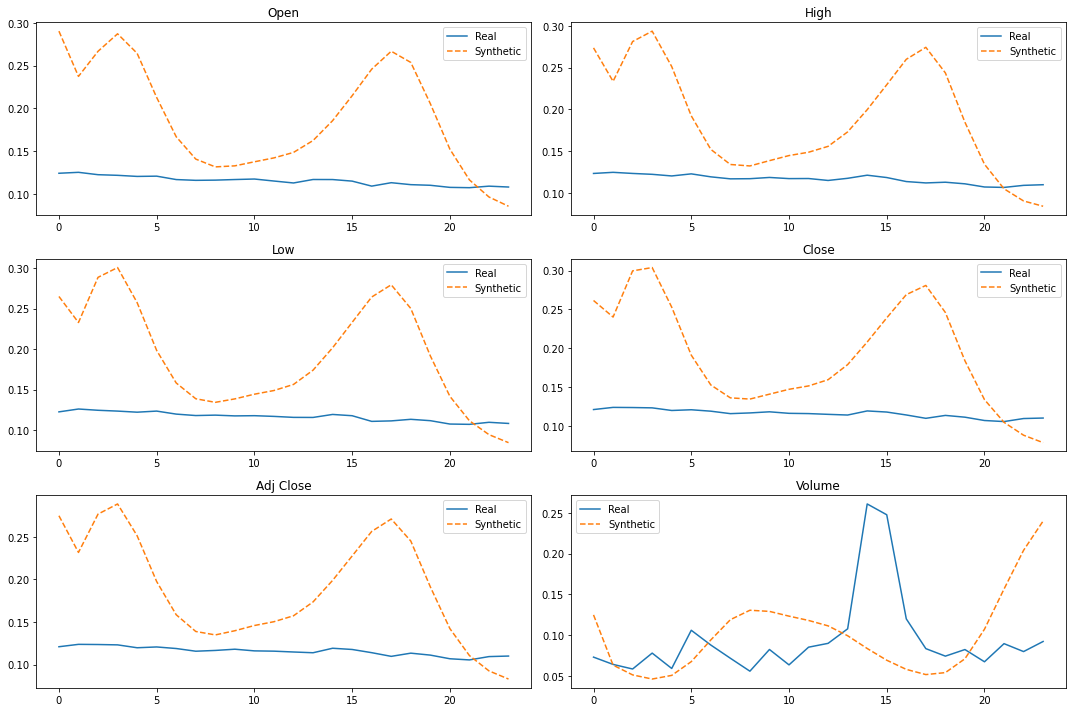

In [ ]:
#Reshaping the data
cols = ['Open','High','Low','Close','Adj Close','Volume']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(stock_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': stock_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()